In [1]:
import pathlib
from itertools import product

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import false_discovery_control, gaussian_kde, mannwhitneyu
from shapely.plotting import patch_from_polygon
from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline
from behavioral_analysis.moseq_tools.plots import create_similarity_dendrogram
from behavioral_analysis.tracking_tools.plots import plot_single_trajectory_overview
from behavioral_analysis.utility.builtin_classes.dicts import invert_flat_dict
from behavioral_analysis.utility.builtin_classes.objects import load_object
from behavioral_analysis.visualization.matplotlib_funcs import add_xy_line, copy_object, create_canvas, multiply_ax_limits, rainbow_text
from behavioral_analysis.visualization.networkx_funcs import plot_connections_from_pair_dict
from behavioral_analysis.visualization.pil_funcs import ensure_pil_image, stitch_image_list, resize_with_preserved_aspect_ratio
from behavioral_analysis.visualization.plots import plot_polygon
from tqdm.cli import tqdm

d:\BITrusted\conda_envs\manuscript2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = pathlib.Path(r"I:\2024_manuscript")

video_dir = root_dir / "videos"
data_output_dir = root_dir / "data_output"
plot_output_dir = root_dir / "plot_output"
trajectory_dir = plot_output_dir / "trajectory_plots"

data_output_dir.mkdir(exist_ok=True, parents=True)
trajectory_dir.mkdir(exist_ok=True, parents=True)

In [3]:
# global parameters
px_per_mm = 0.8653421633554084
contact_threshold = 100  # mm

minimum_syllable_onset_frequency = 0.005
sig_syllables =     [   5,    7,    10, 12, 13, 18, 23, 30]

fps = 25.23
start_frame_limit = int(fps * 30)  # 30 seconds
end_frame_limit = int(fps * 60 * 20)  # 20 minutes

edge_length = 453
diagonal_length = np.sqrt(2) * edge_length

sig_color = sns.color_palette("colorblind")[1]


In [4]:
# plotting parameters

sns.set_theme(style="white")

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams["ps.fonttype"] = 42  # set type 42 (truetype) fonts for ps, instead of type 3
plt.rcParams["pdf.fonttype"] = 42  # set type 42 (truetype) fonts for pdf, instead of type 3
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE, title_fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rc("lines", markersize=2, linewidth=1)
plt.rc("axes", linewidth=0.5)

plt.rc("xtick", bottom=True)
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["xtick.major.width"] = 0.5
plt.rc("ytick", left=True)
plt.rcParams["ytick.major.size"] = 3
plt.rcParams["ytick.major.width"] = 0.5

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage[usenames]{xcolor}")

default_dpi = 300

In [5]:
moseq_df = load_object(data_output_dir / "moseq_df.pkl")

In [6]:
onset_moseq_df = moseq_df.loc[moseq_df["onset"]]
onset_frame_proportions = onset_moseq_df.groupby(["context", "track"])["syllable"].value_counts(normalize=True).sort_index()

syll_onset_frequencies = onset_moseq_df["syllable"].value_counts(normalize=True)
relevant_syllables = syll_onset_frequencies[syll_onset_frequencies.ge(minimum_syllable_onset_frequency)].sort_index().index
relevant_syllables

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype='int64', name='syllable')

In [7]:
syll_pvalues = {}
for syll in relevant_syllables:
    syll_series = onset_frame_proportions.xs(syll, level="syllable")
    res = mannwhitneyu(syll_series.loc["Solitary"].values, syll_series.loc["Dyadic"].values)
    syll_pvalues[syll] = res.pvalue

syll_pvalue_series = pd.Series(syll_pvalues)
corr_syll_pvalue_series = pd.Series(false_discovery_control(syll_pvalue_series.values), index=syll_pvalue_series.index)
sig_syllables = corr_syll_pvalue_series[corr_syll_pvalue_series < 0.05].index
sig_syllables

Index([5, 7, 10, 12, 13, 18, 23, 30], dtype='int64')

# Figure 1

Height: 13.5

Width: 18

First row 

    Panel a: 18x4.5
    
Second row

    Panel b: 3x4.5
    Panel c: 11x4.5
    Panel e: 4x4.5

Third row

    Panel d: 14x4.5
    Panel f: 4x4.5


## Panel A

In [8]:
sampled_syllable_trajectory_df = load_object(data_output_dir / "sampled_syllable_trajectory_df.pkl")
skeleton_df = load_object(data_output_dir / "skeleton_df.pkl")

In [9]:
for syll in tqdm(sampled_syllable_trajectory_df.index.get_level_values("syllable").unique()):
    canvas = create_canvas(256, 256, dpi=default_dpi, alpha=1)
    ax = canvas.gca()

    plot_single_trajectory_overview(sampled_syllable_trajectory_df.loc[syll], skeleton_df, ax=ax, keypoint_kwargs=dict(s=2, lw=1), skeleton_kwargs=dict(lw=1))
    multiply_ax_limits(ax, 1.1)
    canvas.savefig(trajectory_dir / f"Syllable{syll}.png", dpi=default_dpi)
    plt.close(canvas)

100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


3.9962666666666666 2.9972


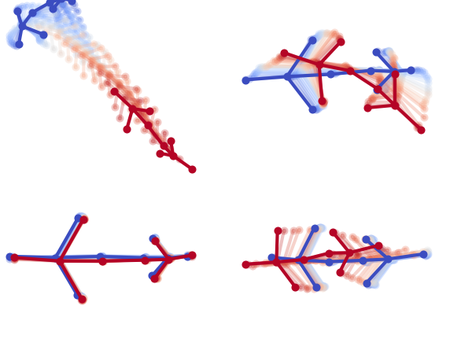

In [10]:
fig_size_cm = (4, 3)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
dpi = default_dpi

fig_size_px = (int(fig_size[0]*dpi), int(fig_size[1]*dpi))

sylls_to_stitch = [2, 3, 6, 7]
syll_path_list = [trajectory_dir / f"Syllable{syll}.png" for syll in sylls_to_stitch]
image_list = [ensure_pil_image(str(path)) for path in syll_path_list]

image_list = [f.crop(box=(0, 25, 300, 250)) for f in image_list]

stitched_image = stitch_image_list(*image_list, columns=2)

stitched_image = resize_with_preserved_aspect_ratio(stitched_image, fig_size_px, resample=Image.Resampling.LANCZOS)

print(stitched_image.width / dpi * 2.54, stitched_image.height / dpi * 2.54)

stitched_image.save(plot_output_dir / "Fig1PanelA3.png", dpi=(dpi, dpi))
stitched_image

## Panel B

In [11]:
distance_sums = load_object(data_output_dir / "distance_sums.pkl")

In [12]:
mannwhitneyu(distance_sums[distance_sums["context"].eq("Dyadic")]["m_moved"], 
             distance_sums[distance_sums["context"].eq("Solitary")]["m_moved"], alternative="less")

MannwhitneyuResult(statistic=np.float64(47.0), pvalue=np.float64(1.852557985281469e-05))

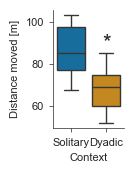

In [13]:
fig_size_cm = (3.5, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, ax = plt.subplots(figsize=fig_size)

ax = sns.boxplot(distance_sums, x="context", y="m_moved", hue="context", palette="colorblind")
ax.set_ylabel("Distance moved [m]")
ax.set_xlabel("Context")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set a star above the right boxplot
x = 1  # the position of the star
y = 90  # the position of the star
ax.annotate("*", (x, y), ha='center', va='center', fontsize=16)

fig.tight_layout()
fig.savefig(plot_output_dir / "Fig1PanelB.svg", dpi=default_dpi)

## Panel C

In [14]:
scored_contact_series = load_object(data_output_dir / "scored_active_contact_series.pkl")

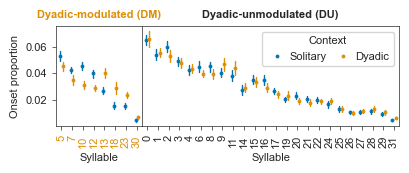

In [15]:
fig_size_cm = (10.5, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(1, 2, figsize=fig_size, sharey=True, gridspec_kw={"width_ratios": [1, 3], "wspace": 0})

ax = axs[0]
sns.pointplot(onset_frame_proportions.loc[:, :, sig_syllables].reset_index(), ax=ax, legend=False, ms=2, lw=1,
                   x="syllable", y="proportion", hue="context", dodge=0.2, linestyles="none", hue_order=["Solitary", "Dyadic"], palette="colorblind")
ax.tick_params(axis="x", rotation=90)
[l.set_color(sig_color) for l in ax.xaxis.get_ticklabels()]
ax.set_title("Dyadic-modulated (DM)", fontdict={"weight": "bold"}, color=sig_color)
ax.set_xlabel("Syllable")
ax.set_ylabel("Onset proportion")

ax = axs[1]
sns.pointplot(onset_frame_proportions.loc[:, :, relevant_syllables].drop(sig_syllables, level="syllable").reset_index(), ax=ax, ms=2, lw=1,
                   x="syllable", y="proportion", hue="context", dodge=0.3, linestyles="none", hue_order=["Solitary", "Dyadic"], palette="colorblind")
ax.tick_params(axis="x", rotation=90)
ax.set_title("Dyadic-unmodulated (DU)", fontdict={"weight": "bold"})
ax.set_xlabel("Syllable")
ax.set_ylabel("Onset proportion")
ax.legend(title="Context", loc="upper right", ncols=2, handletextpad=0.1, columnspacing=0.5)
ax.tick_params(axis="y", left=False)

fig.tight_layout()
fig.savefig(plot_output_dir / "Fig1PanelC.svg", dpi=default_dpi)

## Panel D

In [16]:
active_contact_sig_syll_chi2_df = load_object(data_output_dir / "active_contact_sig_syll_chi2_df.pkl")
renamed_contact_quartile_series = load_object(data_output_dir / "renamed_contact_quartile_series.pkl")

C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\1394899093.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_ticklabels, fontdict={"color": sig_color}, rotation=90)


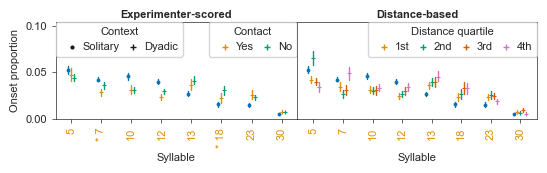

In [17]:
scored_contact_moseq_df = moseq_df.join(scored_contact_series)
scored_contact_moseq_df["comparison_group"] = scored_contact_moseq_df["context"] + scored_contact_moseq_df["contact"].apply({True: ", Yes", False: ", No", np.nan: ""}.get)
plot_syllable_proportions = scored_contact_moseq_df[scored_contact_moseq_df["onset"]]
plot_syllable_proportions = plot_syllable_proportions.groupby(["comparison_group", "track"])["syllable"].value_counts(normalize=True).reset_index()
filtered_plot_syllable_proportions = plot_syllable_proportions[plot_syllable_proportions["syllable"].isin(sig_syllables)]

solitary_data = filtered_plot_syllable_proportions.copy()
solitary_data.loc[solitary_data["comparison_group"].ne("Solitary"), "proportion"] = np.nan

dyadic_data = filtered_plot_syllable_proportions.copy()
dyadic_data.loc[solitary_data["comparison_group"].eq("Solitary"), "proportion"] = np.nan

cmap = sns.color_palette("colorblind")

fig_size_cm = (14, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
fig, axs = plt.subplots(1, 2, figsize=fig_size, sharey=True, gridspec_kw={"width_ratios": [1, 1], "wspace": 0})

ax = axs[0]

sns.pointplot(solitary_data, ms=2, lw=1,
              x="syllable", y="proportion", hue="comparison_group", 
              hue_order=["Solitary", "Dyadic, Yes", "Dyadic, No"], palette="colorblind", 
              marker=["o", "+", "+"],
              dodge=0.2, linestyle="none", errorbar=("ci", 95), ax=ax)

sns.pointplot(dyadic_data, ms=3, lw=1,
              x="syllable", y="proportion", hue="comparison_group", 
              hue_order=["Solitary", "Dyadic, Yes", "Dyadic, No"], palette="colorblind", 
              marker=["o", "+", "+"],
              dodge=0.2, linestyle="none", errorbar=("ci", 95), ax=ax)

ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Experimenter-scored", fontdict={"weight": "bold"}, pad=3)
sns.move_legend(ax, loc="best", title="Context, Contact")
ax.set_ylabel("Onset proportion")
ax.set_xlabel("Syllable")
ax.set_ylim([0, 0.08])

old_ticklabels = [l.get_text() for l in ax.get_xticklabels()]
new_ticklabels = [s if not active_contact_sig_syll_chi2_df.loc[int(s), "significant"] else f"* {s}" for s in old_ticklabels]

#color all x labels with sig_color
ax.set_xticklabels(new_ticklabels, fontdict={"color": sig_color}, rotation=90)

_bin_names = sorted(renamed_contact_quartile_series.unique())
scored_contact_moseq_df = moseq_df.join(renamed_contact_quartile_series)
scored_contact_moseq_df["comparison_group"] = scored_contact_moseq_df["context"] + scored_contact_moseq_df["contact_quartile"].apply(lambda x: ", " + x if not pd.isna(x) else "")
plot_syllable_proportions = scored_contact_moseq_df[scored_contact_moseq_df["onset"]]
plot_syllable_proportions = plot_syllable_proportions.groupby(["comparison_group", "track"])["syllable"].value_counts(normalize=True).reset_index()
filtered_plot_syllable_proportions = plot_syllable_proportions[plot_syllable_proportions["syllable"].isin(sig_syllables)]

solitary_data = filtered_plot_syllable_proportions.copy()
solitary_data.loc[solitary_data["comparison_group"].ne("Solitary"), "proportion"] = np.nan

dyadic_data = filtered_plot_syllable_proportions.copy()
dyadic_data.loc[solitary_data["comparison_group"].eq("Solitary"), "proportion"] = np.nan

ax = axs[1]

sns.pointplot(solitary_data, legend=False, ms=2, lw=1,
              x="syllable", y="proportion", hue="comparison_group", 
              hue_order=["Solitary", "Dyadic, 1st", "Dyadic, 2nd", "Dyadic, 3rd", "Dyadic, 4th"],
              marker=["o", "+", "+", "+", "+"],
              palette="colorblind", 
              dodge=0.4, linestyle="none", errorbar=("ci", 95), ax=ax)

sns.pointplot(dyadic_data, legend=False, ms=3, lw=1,
              x="syllable", y="proportion", hue="comparison_group", 
              hue_order=["Solitary", "Dyadic, 1st", "Dyadic, 2nd", "Dyadic, 3rd", "Dyadic, 4th"],
              marker=["o", "+", "+", "+", "+"],
              palette="colorblind", 
              dodge=0.4, linestyle="none", errorbar=("ci", 95), ax=ax)

ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Distance-based", fontdict={"weight": "bold"}, pad=3)
ax.set_xlabel("Syllable", labelpad=9)
ax.set_ylim([0, 0.08])
ax.tick_params(axis="y", left=False)
[l.set_color(sig_color) for l in ax.xaxis.get_ticklabels()]

ax.set_ylim([0, ax.get_ylim()[1]*1.3])
fig.tight_layout()

legend_cross_multiplier = 7

solitary_marker = ax.scatter([], [], color="k", label="Solitary", s=2*2)
dyadic_marker = ax.scatter([], [], color="k", label="Dyadic", marker="+", s=2*legend_cross_multiplier)

contact_yes_marker = ax.scatter([], [], color=cmap[1], label="Yes", marker="+", s=2*legend_cross_multiplier)
contact_no_marker = ax.scatter([], [], color=cmap[2], label="No", marker="+", s=2*legend_cross_multiplier)

legend1 = axs[0].legend(handles=[solitary_marker, dyadic_marker], title="Context", ncols=2, loc="upper left", handletextpad=0, columnspacing=0.2, borderaxespad=0)
axs[0].legend(handles=[contact_yes_marker, contact_no_marker], title="Contact", loc="upper right", ncols=2, handletextpad=0, columnspacing=0.2, borderaxespad=0)
axs[0].add_artist(legend1)

quartile_markers = [ax.scatter([], [], color=cmap[i+1], label=f"{name}", marker="+", s=2*legend_cross_multiplier) for i, name in enumerate(_bin_names)]
axs[1].legend(handles=quartile_markers, title="Distance quartile", loc="upper right", ncols=4, handletextpad=0, columnspacing=0.2, borderaxespad=0)

fig.tight_layout()

fig.savefig(plot_output_dir / "Fig1PanelD.svg", dpi=default_dpi)

## Panel E

3.9878 4.4958


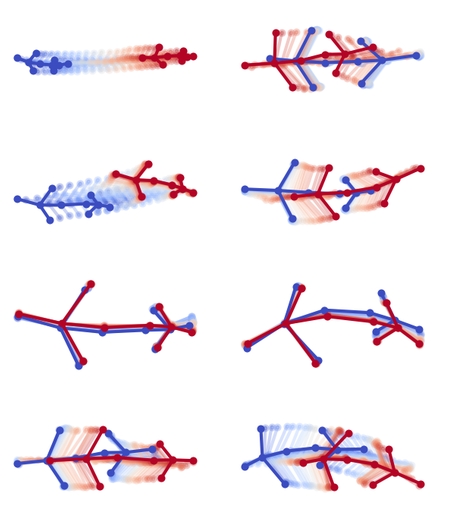

In [18]:
fig_size_cm = (4, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
dpi = default_dpi

fig_size_px = (int(fig_size[0]*dpi), int(fig_size[1]*dpi))

sylls_to_stitch = sig_syllables
syll_path_list = [trajectory_dir / f"Syllable{syll}.png" for syll in sylls_to_stitch]
image_list = [ensure_pil_image(str(path)) for path in syll_path_list]

image_list = [f.crop(box=(0, 50, 300, 225)) for f in image_list]

stitched_image = stitch_image_list(*image_list, columns=2)

stitched_image = resize_with_preserved_aspect_ratio(stitched_image, fig_size_px, resample=Image.Resampling.LANCZOS)

print(stitched_image.width / dpi * 2.54, stitched_image.height / dpi * 2.54)

stitched_image.save(plot_output_dir / "Fig1PanelE.png", dpi=(dpi, dpi))
stitched_image

## Panel F

3.9962666666666666 4.4958


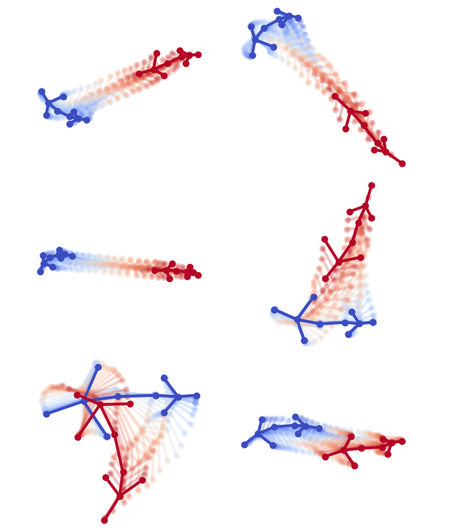

In [19]:
fig_size_cm = (4, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
dpi = default_dpi

fig_size_px = (int(fig_size[0]*dpi), int(fig_size[1]*dpi))

sylls_to_stitch = [0, 2, 8, 9, 11, 22]
syll_path_list = [trajectory_dir / f"Syllable{syll}.png" for syll in sylls_to_stitch]
image_list = [ensure_pil_image(str(path)) for path in syll_path_list]

image_list = [f.crop(box=(0, 0, 300, 260)) for f in image_list]

stitched_image = stitch_image_list(*image_list, columns=2)

stitched_image = resize_with_preserved_aspect_ratio(stitched_image, fig_size_px, resample=Image.Resampling.LANCZOS)

print(stitched_image.width / dpi * 2.54, stitched_image.height / dpi * 2.54)

stitched_image.save(plot_output_dir / "Fig1PanelF.png", dpi=(dpi, dpi))
stitched_image

# Figure 2

Height: 9

Width: 18

First row 

    Panel a: 9x4.5
    
Second row

    Panel b: 9x4.5

Right (Network)

    Panel c: 9x9


## Panel A

In [20]:
distance_df = load_object(data_output_dir / "distance_df.pkl")

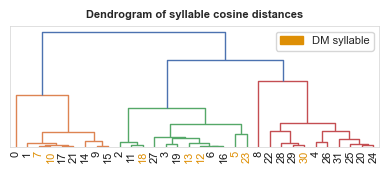

In [21]:
fig_size_cm = (10, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, ax = plt.subplots(figsize=fig_size)
create_similarity_dendrogram(distance_df, ax=ax)
# change x labels to be just the syllable number
ax.set_xticklabels([l.get_text().split(" ")[-1] for l in ax.get_xticklabels()])
# resize x tick labels
ax.tick_params(axis="x", labelsize=SMALL_SIZE)

sig_color = sns.color_palette("colorblind")[1]

label_sylls = [int(l.get_text().split(" ")[-1]) for l in ax.get_xticklabels()]
label_colors = []
for s in label_sylls:
    if s in sig_syllables:
        label_colors.append(sig_color)
    else:
        label_colors.append("k")

[l.set_color(c) for l,c in zip(ax.xaxis.get_ticklabels(), label_colors)]
ax.set_title("Dendrogram of syllable cosine distances", fontweight='bold')
ax.legend(handles=[mpatches.Patch(color=sig_color, label="DM syllable")])

ax.tick_params(axis="x", pad=0)
fig.tight_layout()
fig.savefig(plot_output_dir / "Fig2PanelA.svg", dpi=default_dpi)

## Panel B

In [22]:
separated_eigenvector_centralities = load_object(data_output_dir / "separated_eigenvector_centralities.pkl")
mwu_df = load_object(data_output_dir / "eigenvector_mwu_df.pkl")

C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\3633297171.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_ticklabels, fontdict={"color": sig_color}, rotation=90)
C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\3633297171.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_ticklabels, rotation=90)


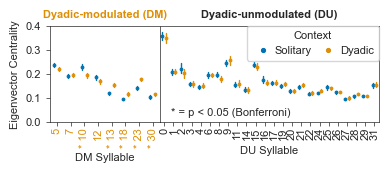

In [23]:
eig_cent_significant_sylls = mwu_df[mwu_df["pvalue"].lt(0.05 / len(mwu_df))].index.get_level_values("syllable").unique()

fig_size_cm = (10, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(1, 2, figsize=fig_size, sharey=True, gridspec_kw={"width_ratios": [1.5, 3], "wspace": 0})

ax = axs[0]
sns.pointplot(separated_eigenvector_centralities[separated_eigenvector_centralities["source"].eq("original") & separated_eigenvector_centralities["dm_syllable"]], legend=False, ms=2, lw=1,
                   x="syllable", y="eigenvector_centrality", hue="context", dodge=0.35, palette="colorblind", linestyle='none', ax=ax, hue_order=["Solitary", "Dyadic"])
old_ticklabels = [l.get_text() for l in ax.get_xticklabels()]
new_ticklabels = [s if int(s) not in eig_cent_significant_sylls else f"* {s}" for s in old_ticklabels]

#color all x labels with sig_color
ax.set_xticklabels(new_ticklabels, fontdict={"color": sig_color}, rotation=90)
ax.tick_params(axis='x', which='both', pad=1)

ax.set_title("Dyadic-modulated (DM)", fontdict={"weight": "bold"}, color=sig_color)
ax.set_xlabel("DM Syllable")
ax.set_ylabel("Eigenvector Centrality")
ax.set_ylim([0, 0.4])

ax = axs[1]
sns.pointplot(separated_eigenvector_centralities[separated_eigenvector_centralities["source"].eq("original") & ~separated_eigenvector_centralities["dm_syllable"]], ms=2, lw=1,
                   x="syllable", y="eigenvector_centrality", hue="context", dodge=0.4, palette="colorblind", linestyle='none', ax=ax, hue_order=["Solitary", "Dyadic"])
old_ticklabels = [l.get_text() for l in ax.get_xticklabels()]
new_ticklabels = [s if int(s) not in eig_cent_significant_sylls else f"* {s}" for s in old_ticklabels]
ax.set_xticklabels(new_ticklabels, rotation=90)
ax.tick_params(axis='x', which='both', pad=1)

ax.set_title("Dyadic-unmodulated (DU)", fontdict={"weight": "bold"})
ax.set_xlabel("DU Syllable")
ax.set_ylabel("Eigenvector Centrality")
ax.set_ylim([0, 0.4])

handles, labels = ax.get_legend_handles_labels()
[h.set_markersize(3) for h in handles]

ax.legend(handles=handles, labels=labels, title="Context", loc="upper right", ncols=2, handletextpad=0.1, columnspacing=0.5, borderaxespad=0)
# bottom left text: * = p < 0.05
ax.text(0.05, 0.05, "* = p < 0.05 (Bonferroni)", transform=ax.transAxes, fontsize=SMALL_SIZE, va='bottom', ha='left')
ax.tick_params(axis="y", left=False)

fig.tight_layout()

fig.savefig(plot_output_dir / "Fig2PanelB.svg", dpi=default_dpi)

## Panel C

In [24]:
delta_median_eig_cent = load_object(data_output_dir / "delta_median_eig_cent.pkl")
filtered_delta_trans = load_object(data_output_dir / "filtered_delta_trans.pkl")

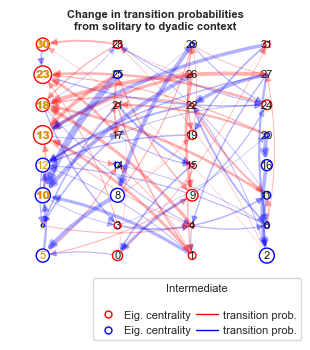

In [25]:
eig_cent_significant_sylls = mwu_df[mwu_df["pvalue"].lt(0.05 / len(mwu_df))].index.get_level_values("syllable").unique()

fig_size_cm = (8, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

non_sig_syllables = list(set(range(32)) - set(sig_syllables))
non_sig_parts = 3
partite_layers = {
    0: sig_syllables,
}
partite_layers.update({i+1: non_sig_syllables[i::non_sig_parts] for i in range(non_sig_parts)})

def _partial_partite(g):
    return nx.layout.multipartite_layout(g, subset_key=partite_layers)

fig, ax = plt.subplots(figsize=fig_size)
ax, artists, g = plot_connections_from_pair_dict(filtered_delta_trans.to_dict(), 
                                                    edge_labels="", 
                                                    edge_weights=lambda x: np.abs(x),
                                                    edge_widths=lambda x: np.abs(x*25),
                                                    edge_colors=lambda x: "white" if x==0 else ("blue" if x < 0 else "red"),
                                                    node_labels=lambda x: "",
                                                    node_colors=lambda x: "white",
                                                    node_edgecolors=lambda x: "blue" if delta_median_eig_cent.loc[x, "eigenvector_centrality"] < 0 else "red",
                                                    node_sizes=lambda x: delta_median_eig_cent.abs().loc[x, "eigenvector_centrality"]*5000,
                                                    directed=True, positions=_partial_partite, ax=ax, label_font_size=SMALL_SIZE)



node_labels = {x: rf"{x}" if x not in eig_cent_significant_sylls else "" for x in g.nodes}
_sig_node_labels = {k: v for k, v in node_labels.items() if k in sig_syllables}
_non_sig_node_labels = {k: v for k, v in node_labels.items() if k not in sig_syllables}
nx.draw_networkx_labels(g, pos=_partial_partite(g), ax=ax, labels=_sig_node_labels, font_size=SMALL_SIZE, font_color=sig_color)
nx.draw_networkx_labels(g, pos=_partial_partite(g), ax=ax, labels=_non_sig_node_labels, font_size=SMALL_SIZE)

node_labels = {x: rf"{x}" if x in eig_cent_significant_sylls else "" for x in g.nodes}
_sig_node_labels = {k: v for k, v in node_labels.items() if k in sig_syllables}
_non_sig_node_labels = {k: v for k, v in node_labels.items() if k not in sig_syllables}
nx.draw_networkx_labels(g, pos=_partial_partite(g), ax=ax, labels=_sig_node_labels, font_size=SMALL_SIZE, font_weight="heavy", font_color=sig_color)
nx.draw_networkx_labels(g, pos=_partial_partite(g), ax=ax, labels=_non_sig_node_labels, font_size=SMALL_SIZE)

ax.set_title("Change in transition probabilities\nfrom solitary to dyadic context", fontdict={"weight": "bold"}, y=.9)

# two legends: one with colors, one with line and node markers

legend_elements = [
    mlines.Line2D([], [], color="white", markeredgecolor="red", marker="o", ms=5, label="Eig. centrality"),
    mlines.Line2D([], [], color="white", markeredgecolor="blue", marker="o", ms=5, label="Eig. centrality"),
    mlines.Line2D([], [], color="red", label="transition prob."),
    mlines.Line2D([], [], color="blue", label="transition prob."),
]
ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.00, 0), ncols=2,
                    title="Intermediate\n", handletextpad=0.4, columnspacing=0.5, borderaxespad=0, fontsize=SMALL_SIZE)

#remove border around plot
ax.axis("off")

fig = ax.get_figure()

fig.tight_layout()

fig.savefig(plot_output_dir / "Fig2PanelC.svg", dpi=default_dpi)

# Figure 3

Height: 9

Width: 18

First row 

    Panel a: 4.5x4.5
    Panel b: 13.5x4.5
    
Second row

    Panel c: 18x4.5


## Panel A

In [26]:
# Is an image

## Panel B

In [27]:
eval_series_dict = load_object(data_output_dir / "eval_series_dict.pkl")
joint_significance_dict = load_object(data_output_dir / "joint_significance_dict.pkl")
across_eval_series_dict = load_object(data_output_dir / "across_eval_series_dict.pkl")
across_joint_significance_dict = load_object(data_output_dir / "across_joint_significance_dict.pkl")

C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\23615964.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.08, 1, 1])


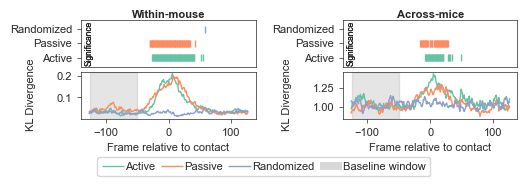

In [28]:
cmap = sns.color_palette("Set2")

color_dict = {
    "Active": cmap[0],
    "Passive": cmap[1],
    "Randomized": cmap[2]
}
baseline_slice = slice(-125, -50, 1)

fig_size_cm = (13.5, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(2, 2, figsize=fig_size, sharex=True, height_ratios=[0.5, 0.5], layout="constrained")

for i, (label, eval_series) in enumerate(eval_series_dict.items()):
    joint_significance_series = joint_significance_dict[label]
    joint_significant_indices = joint_significance_series[joint_significance_series].index
    axs[0, 0].eventplot(joint_significant_indices, lineoffsets=label, linelengths=0.5, color=color_dict[label], label=label, lw=1)
    axs[0, 0].text(0.02, 0.02, "Significance", rotation=90, ha="left", va="bottom", transform=axs[0, 0].transAxes, fontsize=int(SMALL_SIZE*0.75))
    if joint_significant_indices.empty:
        axs[0, 0].eventplot([0], lineoffsets=label, linelengths=0.5, color="white", alpha=0)

    axs[1, 0].plot(eval_series.index, eval_series, color=color_dict[label], label=label, lw=1)
# add shaded area for baseline slice
axs[1, 0].axvspan(baseline_slice.start, baseline_slice.stop, color="gray", alpha=0.2)

for i, (label, eval_series) in enumerate(across_eval_series_dict.items()):
    joint_significance_series = across_joint_significance_dict[label]
    joint_significant_indices = joint_significance_series[joint_significance_series].index
    axs[0, 1].eventplot(joint_significant_indices, lineoffsets=label, linelengths=0.5, color=color_dict[label], label=label, lw=1)
    axs[0, 1].text(0.02, 0.02, "Significance", rotation=90, ha="left", va="bottom", transform=axs[0, 1].transAxes, fontsize=int(SMALL_SIZE*0.75))
    if joint_significant_indices.empty:
        axs[0, 1].eventplot([0], lineoffsets=label, linelengths=0.5, color="white", label=label, alpha=0)
    axs[1, 1].plot(eval_series.index, eval_series, color=color_dict[label], label=label, lw=1)
# add shaded area for baseline slice
axs[1, 1].axvspan(baseline_slice.start, baseline_slice.stop, color="gray", alpha=0.2)

axs[0, 0].set_title("Within-mouse", pad=0, fontweight="bold")
axs[0, 1].set_title("Across-mice", pad=0, fontweight="bold")
axs[0, 0].tick_params(axis="x", bottom=False)
axs[0, 1].tick_params(axis="x", bottom=False)

axs[1, 0].set_ylabel("KL Divergence", labelpad=15)
axs[1, 1].set_ylabel("KL Divergence", labelpad=15)

axs[1, 0].set_xlabel("Frame relative to contact")
axs[1, 1].set_xlabel("Frame relative to contact")

# create space for suptitle
plt.tight_layout(rect=[0, 0.08, 1, 1])

# legend in a box below the figure
handles, labels = axs[0, 0].get_legend_handles_labels()
# add a handle of a gray patch for the baseline slice
handles.append(plt.Rectangle((0,0),1,1,fc="gray", edgecolor = 'none', alpha=0.3))
labels.append("Baseline window")

fig.legend(handles, labels, loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 0.125), handletextpad=0.1, columnspacing=0.5, borderaxespad=0)
plt.subplots_adjust(hspace=0.1, wspace=0.5, top=0.9)

fig.savefig(plot_output_dir / "Fig3PanelB.svg", dpi=default_dpi)

## Panel C

In [29]:
global_g_frequency_df = load_object(data_output_dir / "global_g_frequency_df.pkl")

In [30]:
def slice_baseline_zscore(eval_series, baseline_slice=None):
    if baseline_slice is None:
        baseline_slice = slice(-125, -50, 1)
    baseline_slice_series = eval_series.loc[baseline_slice]
    slice_eval_z_score = (eval_series - baseline_slice_series.mean()) / baseline_slice_series.std()
    return slice_eval_z_score

baseline_slice=slice(-125, -50, 1)
global_slice_zscore_df = global_g_frequency_df.apply(slice_baseline_zscore, baseline_slice=baseline_slice, axis=1)
plot_df = global_slice_zscore_df.stack(future_stack=True).rename("z_score").to_frame()
plot_df = plot_df.join(global_g_frequency_df.stack(future_stack=True).rename("frequency"))

significant_syntax = global_slice_zscore_df.loc[:, -50:50].abs().ge(3).sum(axis=1).ge(50)

top10_abs_zscore_auc = global_slice_zscore_df.loc[:, -50:50].abs().apply(lambda x: auc(x.index, x), axis=1).sort_values(ascending=False).groupby("contact_type").head(10)

active_slice_zscore_df = global_slice_zscore_df.xs("Active", level="contact_type", drop_level=True)
top4_active_syntaxes = top10_abs_zscore_auc.xs("Active", level="contact_type").head(4).index

passive_slice_zscore_df = global_slice_zscore_df.xs("Passive", level="contact_type", drop_level=True)
top4_passive_syntaxes = top10_abs_zscore_auc.xs("Passive", level="contact_type").head(4).index

active_significant_syntax = significant_syntax.xs("Active", level="contact_type")
active_significant_syntax_index = active_significant_syntax[active_significant_syntax].index

passive_significant_syntax = significant_syntax.xs("Passive", level="contact_type")
passive_significant_syntax_index = passive_significant_syntax[passive_significant_syntax].index

In [31]:
act_synt = global_slice_zscore_df.loc[:, -50:50].abs().ge(3).sum(axis=1).ge(50).loc[pd.IndexSlice[:, "Active"]]
pass_synt = global_slice_zscore_df.loc[:, -50:50].abs().ge(3).sum(axis=1).ge(50).loc[pd.IndexSlice[:, "Passive"]]
random_synt = global_slice_zscore_df.loc[:, -50:50].abs().ge(3).sum(axis=1).ge(50).loc[pd.IndexSlice[:, "Randomized"]]

In [32]:
print(len(act_synt[act_synt]))
act_synt[act_synt]

25


syllable_pattern
(0, 5, 1)       True
(0, 5, 3)       True
(0, 5, 9)       True
(0, 5, 19)      True
(0, 25, 10)     True
(2, 8, 19)      True
(2, 22, 2)      True
(3, 18, 11)     True
(4, 6, 3)       True
(4, 11, 2)      True
(5, 9, 0)       True
(7, 4, 6)       True
(7, 4, 18)      True
(9, 0, 5)       True
(11, 2, 22)     True
(11, 28, 18)    True
(13, 4, 6)      True
(15, 0, 5)      True
(18, 11, 2)     True
(20, 16, 2)     True
(20, 21, 7)     True
(21, 1, 13)     True
(22, 2, 8)      True
(22, 6, 11)     True
(22, 6, 12)     True
dtype: bool

In [33]:
print(len(pass_synt[pass_synt]))
pass_synt[pass_synt]

25


syllable_pattern
(0, 5, 1)       True
(0, 5, 14)      True
(0, 25, 10)     True
(0, 31, 0)      True
(2, 8, 5)       True
(2, 8, 19)      True
(2, 8, 29)      True
(2, 22, 12)     True
(3, 4, 6)       True
(3, 18, 11)     True
(3, 20, 21)     True
(4, 18, 11)     True
(7, 4, 18)      True
(8, 5, 10)      True
(9, 0, 5)       True
(9, 0, 19)      True
(9, 0, 25)      True
(11, 18, 11)    True
(11, 28, 18)    True
(15, 0, 5)      True
(18, 11, 18)    True
(20, 21, 1)     True
(21, 1, 13)     True
(25, 9, 0)      True
(31, 0, 5)      True
dtype: bool

In [34]:
act_synt[act_synt].index.intersection(pass_synt[pass_synt].index)

Index([   (0, 5, 1),  (0, 25, 10),   (2, 8, 19),  (3, 18, 11),   (7, 4, 18),
          (9, 0, 5), (11, 28, 18),   (15, 0, 5),  (21, 1, 13)],
      dtype='object', name='syllable_pattern')

In [35]:
act_synt[act_synt].index.intersection(pass_synt[pass_synt].index)

Index([   (0, 5, 1),  (0, 25, 10),   (2, 8, 19),  (3, 18, 11),   (7, 4, 18),
          (9, 0, 5), (11, 28, 18),   (15, 0, 5),  (21, 1, 13)],
      dtype='object', name='syllable_pattern')

In [36]:
def intersperse(lst, item):
    """
    from https://stackoverflow.com/a/5921708
    """
    result = [item] * (len(lst) * 2 - 1)
    result[0::2] = lst
    return result


def _color_legend_sylls(input_legend):
    for l in input_legend.get_texts():
        t_text = l.get_text()
        t_sylls = [str(s) for s in eval(t_text)]
        syll_texts = ["(", *intersperse(t_sylls, ", "), ")"]
        sig_syll_strings = [str(s) for s in sig_syllables]
        syll_colors = [sig_color if s in sig_syll_strings else "black" for s in syll_texts]
        print(syll_texts, syll_colors, sig_syll_strings)
        b = rainbow_text(l, syll_texts, syll_colors)
        b.set_zorder(100)
        # only looks uneven, pdf is fine


21
79
['(', '0', ', ', '5', ', ', '9', ')'] ['black', 'black', 'black', (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'black', 'black', 'black'] ['5', '7', '10', '12', '13', '18', '23', '30']
['(', '2', ', ', '22', ', ', '2', ')'] ['black', 'black', 'black', 'black', 'black', 'black', 'black'] ['5', '7', '10', '12', '13', '18', '23', '30']
['(', '22', ', ', '2', ', ', '8', ')'] ['black', 'black', 'black', 'black', 'black', 'black', 'black'] ['5', '7', '10', '12', '13', '18', '23', '30']
['(', '11', ', ', '2', ', ', '22', ')'] ['black', 'black', 'black', 'black', 'black', 'black', 'black'] ['5', '7', '10', '12', '13', '18', '23', '30']
21
79
['(', '21', ', ', '1', ', ', '13', ')'] ['black', 'black', 'black', 'black', 'black', (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'black'] ['5', '7', '10', '12', '13', '18', '23', '30']
['(', '2', ', ', '8', ', ', '29', ')'] ['black', 'black', 'black', 'black', 'black', 'black', 'black'] ['5', '7', '10', '12', '13',

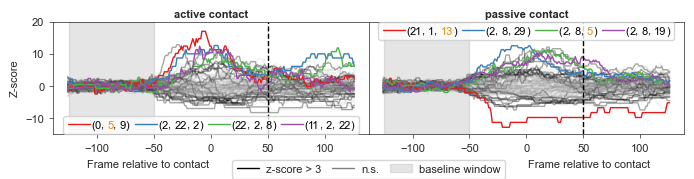

In [37]:
fig_size_cm = (18, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(1, 2, figsize=fig_size, sharey=True, gridspec_kw={"width_ratios": [1, 1], "wspace": 0})
cmap = sns.color_palette("Set1", len(top4_active_syntaxes))

ax = axs[0]

remaining_lines = active_slice_zscore_df.drop(top4_active_syntaxes)
significant_remaining_lines = remaining_lines.loc[remaining_lines.index.isin(active_significant_syntax_index)]
left_significant_remaining_lines = significant_remaining_lines
insignificant_remaining_lines = remaining_lines.loc[~remaining_lines.index.isin(active_significant_syntax_index)]
left_insignificant_remaining_lines = insignificant_remaining_lines

print(len(significant_remaining_lines))
print(len(insignificant_remaining_lines))

ax.plot(significant_remaining_lines.columns, significant_remaining_lines.values.T, color="black", alpha=0.35, label=None, lw=1)
ax.plot(insignificant_remaining_lines.columns, insignificant_remaining_lines.values.T, color="gray", alpha=0.1, label=None, lw=1)

for i, syll_pattern in enumerate(top4_active_syntaxes):
    active_slice_zscore_df.loc[[syll_pattern]].iloc[0].plot(ax=ax, color=cmap[i], label=syll_pattern, lw=1)

# draw hashed baseline rectangle
ax.axvspan(baseline_slice.start, baseline_slice.stop, color="gray", alpha=0.2, label=None)
ax.axvline(50, color="black", linestyle="--", label=None)

ax.set_title("Active")

background_legend_handles = [
    Line2D([0], [0], color="black", label="z-score > 3"),
    Line2D([0], [0], color="gray", label="n.s."),
    mpatches.Patch(color="gray", alpha=0.2, label="baseline window")
]
background_legend = ax.legend(handles=background_legend_handles, loc="upper center", bbox_to_anchor=(1, -0.225), ncols=3, handletextpad=0.6, columnspacing=1.0, borderaxespad=0)
l = ax.legend(loc="lower center", ncols=4, bbox_to_anchor=(0.5, 0), handletextpad=0.1, columnspacing=0.5, borderaxespad=0)
_color_legend_sylls(l)
ax.add_artist(background_legend)
ax.set_ylabel("Z-score")

ax.set_xlabel("Frame relative to contact", x=0.3)

ax.set_title("active contact", weight="bold", pad=3)
ax.set_ylim([-15, 20])

ax = axs[1]

remaining_lines = passive_slice_zscore_df.drop(top4_passive_syntaxes)
significant_remaining_lines = remaining_lines.loc[remaining_lines.index.isin(passive_significant_syntax_index)]
right_significant_remaining_lines = significant_remaining_lines
insignificant_remaining_lines = remaining_lines.loc[~remaining_lines.index.isin(passive_significant_syntax_index)]
right_insignificant_remaining_lines = insignificant_remaining_lines

print(len(significant_remaining_lines))
print(len(insignificant_remaining_lines))

ax.plot(significant_remaining_lines.columns, significant_remaining_lines.values.T, color="black", alpha=0.35, label=None, lw=1)
ax.plot(insignificant_remaining_lines.columns, insignificant_remaining_lines.values.T, color="gray", alpha=0.1, label=None, lw=1)

for i, syll_pattern in enumerate(top4_passive_syntaxes):
    passive_slice_zscore_df.loc[[syll_pattern]].iloc[0].plot(ax=ax, color=cmap[i], label=syll_pattern, lw=1)

ax.axvspan(baseline_slice.start, baseline_slice.stop, color="gray", alpha=0.2, label=None)
ax.axvline(50, color="black", linestyle="--", label=None)

l = ax.legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5, 1), handletextpad=0.1, columnspacing=0.5, borderaxespad=0)

_color_legend_sylls(l)

ax.set_ylabel("Z-score")
ax.tick_params(axis="y", left=False)

ax.set_xlabel("Frame relative to contact", x=0.7)

ax.set_title("passive contact", weight="bold", pad=3)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.savefig(plot_output_dir / "Fig3PanelC.svg", dpi=default_dpi)

# Figure 4

Height: 18

Width: 18

First row 

    Panel a1: 6x6
    Panel a2: 6x6
    Panel b: 6x12
    
Second row

    Panel c1: 6x6
    Panel c2: 6x6

Third row

    Panel d: 6x6
    Panel e: 12x6


## Panel A

In [38]:
dyadic_sampled_centroids = load_object(data_output_dir / "dyadic_sampled_centroids.pkl")

d:\BITrusted\conda_envs\manuscript2024\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'aspect', 'lw'
  cset = contour_func(


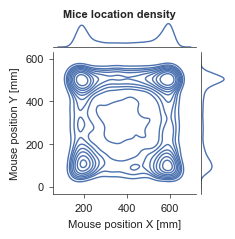

In [39]:
fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

p = sns.jointplot(dyadic_sampled_centroids, x="centroid_x", y="centroid_y", kind="kde", height=fig_size[0], aspect=1, lw=1)

p.ax_joint.set_xlabel("Mouse position X [mm]")
p.ax_joint.set_ylabel("Mouse position Y [mm]")

fig.tight_layout()
p.figure.suptitle("Mice location density", fontweight='bold', fontsize=SMALL_SIZE)
p.figure.subplots_adjust(top=0.925) # Reduce plot to make room 

p.ax_marg_x.tick_params(axis="x", bottom=False)
p.ax_marg_y.tick_params(axis="y", left=False)

p.figure.savefig(plot_output_dir / "Fig4PanelA.svg", dpi=default_dpi)

## Panel B

In [40]:
distance_hist_series = load_object(data_output_dir / "distance_hist_series.pkl")
observed_shuffled_delta = load_object(data_output_dir / "observed_shuffled_delta.pkl")

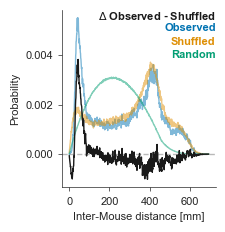

In [41]:
fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, ax = plt.subplots(figsize=fig_size)

sns.lineplot(distance_hist_series.reset_index(), x="mouse_distance", y="density", hue="distance_type", palette="colorblind", legend=False, alpha=0.5, ax=ax)
ax.plot(observed_shuffled_delta.index, observed_shuffled_delta, color="k", label="$\Delta$ Obs./Shuff.")
ax.set_xlabel("Inter-Mouse distance [mm]")
ax.set_ylabel("Probability")
ax.axhline(0, color="k", ls="--", alpha=0.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add colored text inplace of a legend in the top right corner
txt = ax.text(1, 1, "$\Delta$ Observed - Shuffled", ha='right', va='top', transform=ax.transAxes, color="k", fontsize=SMALL_SIZE, fontweight="bold")
ax.text(1, 0.925, "Observed", ha='right', va='top', transform=ax.transAxes, color=sns.color_palette("colorblind")[0], fontsize=SMALL_SIZE, fontweight="bold")
ax.text(1, 0.85, "Shuffled", ha='right', va='top', transform=ax.transAxes, color=sns.color_palette("colorblind")[1], fontsize=SMALL_SIZE, fontweight="bold")
ax.text(1, 0.775, "Random", ha='right', va='top', transform=ax.transAxes, color=sns.color_palette("colorblind")[2], fontsize=SMALL_SIZE, fontweight="bold")
fig.tight_layout()

fig.savefig(plot_output_dir / "Fig4PanelB.svg", dpi=default_dpi)

## Panel C

In [42]:
global_match_df_copy = load_object(data_output_dir / "global_match_df_copy.pkl")
pattern_match_df_copy = load_object(data_output_dir / "pattern_match_df_copy.pkl")
clean_polygon_dict = load_object(data_output_dir / "clean_polygon_dict.pkl")

rename_dict = {
    "targeted_approach": "approach",
    "targeted_leave": "leave",
    "stationary_no_contact": "contact_control",
}
clean_polygon_dict = {rename_dict.get(k, k): v for k, v in clean_polygon_dict.items()}
clean_polygon_dict

{'contact': <POLYGON ((50 -50, 0 0, 0 50, 50 50, 100 0, 100 -50, 50 -50))>,
 'leave': <POLYGON ((50 50, 0 100, 0 640, 100 540, 100 50, 50 50))>,
 'leave_control': <POLYGON ((100 540, 200 440, 200 50, 100 50, 100 540))>,
 'approach': <POLYGON ((640 -640, 100 -100, 100 -50, 150 -50, 640 -540, 640 -640))>,
 'approach_control': <POLYGON ((640 -540, 640 -540, 150 -50, 250 -50, 640 -440, 640 -540))>,
 'contact_control': <POLYGON ((250 -50, 200 0, 200 50, 590 50, 640 0, 640 -50, 250 -50))>}

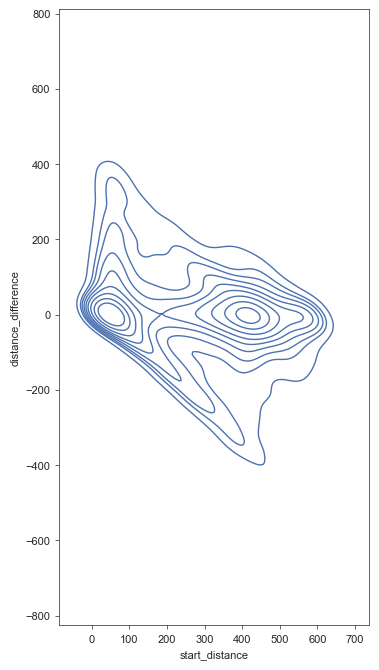

In [43]:
kde_fig, ax = plt.subplots(figsize=((4, 8)))
sns.kdeplot(global_match_df_copy, x="start_distance", y="distance_difference", ax=ax)
ax.set_aspect('equal', adjustable='datalim')

In [44]:
fig_size_cm = (6, 12)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

kde_fig.set_size_inches(fig_size)

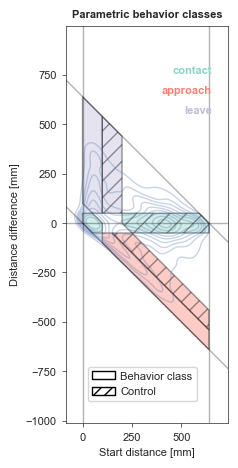

In [45]:
cmap = plt.get_cmap("Set3")

fig_copy = copy_object(kde_fig)
ax = fig_copy.gca()
ax.collections[0].set_alpha(0.3)

polygon_colors = {
    "contact": cmap(0),
    "approach": cmap(3),
    "leave": cmap(2),
    "contact_control": cmap(0),
    "approach_control": cmap(3),
    "leave_control": cmap(2),
}

_text_shift = 0.05
n_labels = 0
for i, k in enumerate(["contact", "approach", "leave", "contact_control", "approach_control", "leave_control"]):
    v = clean_polygon_dict[k]
    _c = list(polygon_colors[k])
    _c[-1] = 0.4
    ax.add_artist(patch_from_polygon(v, hatch="//" if "control" in k else "", edgecolor=(0, 0, 0, 0.4), facecolor=_c))
    if not "control" in k:
        ax.text(0.9, 0.9-_text_shift*n_labels, k, ha='right', va='top', transform=ax.transAxes, color=polygon_colors[k], fontsize=SMALL_SIZE, fontweight="bold")
        n_labels += 1

add_xy_line(ax, -1, 0, color="black", linestyle="-", alpha=0.3)
add_xy_line(ax, -1, diagonal_length, color="black", linestyle="-", alpha=0.3)
ax.axvline(0, color="black", linestyle="-", alpha=0.3)
ax.axvline(diagonal_length, color="black", linestyle="-", alpha=0.3)
ax.axhline(0, color="black", linestyle="-", alpha=0.3)
ax.set_aspect('equal', adjustable='datalim')

# add a legend with one hatched and one clear patch at the bottom left
handles = [mpatches.Patch(facecolor="white", edgecolor="black", label="Behavior class"), mpatches.Patch(facecolor="white", edgecolor="black", hatch="///", label="Control")]
ax.legend(handles=handles, loc="lower left", handletextpad=0.5, columnspacing=0.5, borderaxespad=2)

ax.set_title("Parametric behavior classes", weight="bold")
ax.set_xlabel("Start distance [mm]")
ax.set_ylabel("Distance difference [mm]")

fig_copy.tight_layout()
fig_copy.savefig(plot_output_dir / "Fig4PanelC.svg", dpi=default_dpi)
fig_copy

## Panel D

In [46]:
rolling_df = load_object(data_output_dir / "rolling_df.pkl")

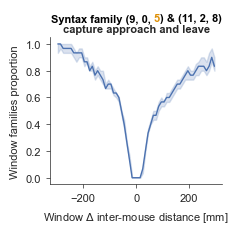

In [47]:
fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, ax = plt.subplots(figsize=fig_size)
sns.lineplot(data=rolling_df, x="delta_distance_bin", y="window_pattern_prop", estimator="median", errorbar=("ci", 95), ax=ax)
ax.set_xlabel("Window $\Delta$ inter-mouse distance [mm]")
ax.set_ylabel("Window families proportion")
ax.set_title(f"Syntax family (9, 0, 5) & (11, 2, 8)", weight="bold", y=1.05)
ax.text(0.5, 1.02, "capture approach and leave", weight="bold", ha='center', va="bottom", transform=ax.transAxes)
rainbow_text(ax.title, ["Syntax family (9, 0, ", "5", ") & (11, 2, 8)"], ["black", sig_color, "black"])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig(plot_output_dir / "Fig4PanelD.svg", dpi=default_dpi)

## Panel E

In [48]:
def kde2D(x, y, bandwidth, x_bin_edges, y_bin_edges, **kwargs): 
    # adapted from https://stackoverflow.com/a/41639690
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.meshgrid(x_bin_edges, y_bin_edges)

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [49]:
padding = 150
point_spacing = 5

target_families = [(9, 0, 5), (11, 2, 8)]

x_positions = np.arange(-padding, diagonal_length+padding+point_spacing, point_spacing)
y_positions = np.arange(-diagonal_length-padding, diagonal_length+padding+point_spacing, point_spacing)

X, Y = np.meshgrid(x_positions, y_positions)
positions = np.vstack([X.ravel(), Y.ravel()])

background_data = global_match_df_copy
background_kde = gaussian_kde(background_data[['start_distance', 'distance_difference']].T)
background_z = np.reshape(background_kde(positions).T, X.shape)
background_z /= background_z.sum()

_raw_pattern_kdes = []
_pattern_kdes = []
for i, target_family in enumerate(target_families):
    _pattern_match_df = pattern_match_df_copy[pattern_match_df_copy["syllable_pattern"] == target_family]
    _pattern_kde = gaussian_kde(_pattern_match_df[['start_distance', 'distance_difference']].T)
    _pattern_z = np.reshape(_pattern_kde(positions).T, X.shape)
    _pattern_z /= _pattern_z.sum()

    _raw_pattern_kdes.append(_pattern_kde)

    _kde_delta = _pattern_z - background_z
    _delta_median = np.median(_kde_delta)
    _delta_mad = np.median(np.abs(_kde_delta - _delta_median))
    _robust_zscore_delta = 0.6745 * (_kde_delta - _delta_median) / _delta_mad
    _pattern_kdes.append(_robust_zscore_delta)

(np.float64(-152.5), np.float64(797.5)) (np.float64(-790.6387437550121), np.float64(790.6387437550121))
(np.float64(-152.5), np.float64(797.5)) (np.float64(-790.6387437550121), np.float64(790.6387437550121))


C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\2897559796.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\2897559796.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


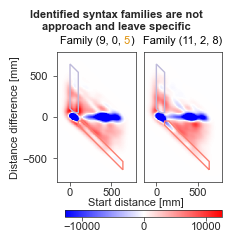

In [50]:
fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(1, len(target_families), figsize=fig_size, sharey=True)

lower_cutoff = -np.max(_pattern_kdes)
upper_cutoff = np.max(_pattern_kdes)

family_strings_and_colors = {
    (9, 0, 5): (["Family (9, 0, ", "5", ")"], ["black", sig_color, "black"]),
    (11, 2, 8): (["Family (11, 2, 8)"], ["black"]),
}

for i, (target_family, pattern_ax, _pattern_kde) in enumerate(zip(target_families, axs.flatten(), _pattern_kdes)):
    pattern_ax.pcolormesh(x_positions, y_positions, _pattern_kde, cmap="bwr", vmin=min(lower_cutoff, -upper_cutoff), vmax=max(upper_cutoff, -lower_cutoff))

    plot_polygon(clean_polygon_dict["approach"], name=None, ax=pattern_ax, polygon_kwargs=dict(fill=False, alpha=1, color=polygon_colors["approach"], zorder=10))
    plot_polygon(clean_polygon_dict["leave"], name=None, ax=pattern_ax, polygon_kwargs=dict(fill=False, alpha=1, color=polygon_colors["leave"], zorder=10))

    title_string = f"Family {target_family}"
    pattern_ax.set_title(title_string)

    rainbow_text(pattern_ax.title, *family_strings_and_colors[target_family])

    if i==0:
        pattern_ax.set_xlabel("Start distance [mm]")
        pattern_ax.xaxis.set_label_coords(x=1, y=-0.115)
        pattern_ax.set_ylabel("Distance difference [mm]", labelpad=2)
        pattern_ax.tick_params(pad=1, axis="x")
        pattern_ax.tick_params(pad=4, axis="y")

    else:
        pattern_ax.set_xlabel("")
        pattern_ax.set_ylabel("")
        pattern_ax.tick_params(pad=1, axis="x")
        pattern_ax.tick_params(pad=4, axis="y", left=False)
    pattern_ax.set_ylim([-diagonal_length-padding, diagonal_length+padding])
    pattern_ax.set_aspect('equal')

    print(pattern_ax.get_xlim(), pattern_ax.get_ylim())

axins = inset_axes(axs.flatten()[1],
                    width="200%",  
                    height="5%",
                    bbox_to_anchor=(-0.0, -1.215, 1, 1),
                    bbox_transform=axs.flatten()[1].transAxes,
                    borderpad=0
                   )

cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=min(lower_cutoff, -upper_cutoff), vmax=max(upper_cutoff, -lower_cutoff)), cmap="bwr"), cax=axins, orientation="horizontal")
cb.ax.tick_params(pad=0)

fig.tight_layout()
fig.suptitle("Identified syntax families are not\napproach and leave specific", weight="bold", fontsize=SMALL_SIZE)

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.2, hspace=0, wspace=0.1)

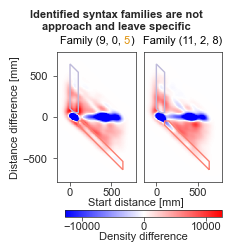

In [51]:
text = cb.ax.xaxis.get_offset_text()
text.set_visible(False)
axins.text(1, -2.25, s=text.get_text(), transform=axins.transAxes, va="top", ha="right")
axins.set_xlabel("Density difference", labelpad=0)
fig.savefig(plot_output_dir / "Fig4PanelE.svg", dpi=default_dpi)
fig

## Panel F

In [52]:
polygon_dkl_series = load_object(data_output_dir / "polygon_dkl_series.pkl")
syntax_polygon_dkl_series = load_object(data_output_dir / "syntax_polygon_dkl_series.pkl")

In [53]:
cmap = plt.get_cmap("Set3")

polygon_colors = {
    "contact": cmap(0),
    "approach": cmap(3),
    "leave": cmap(2),
    "contact_control": cmap(0),
    "approach_control": cmap(3),
    "leave_control": cmap(2),
}

# rename index entries with rename_dict
polygon_dkl_series = polygon_dkl_series.rename(rename_dict)
syntax_polygon_dkl_series = syntax_polygon_dkl_series.rename(rename_dict)

second_rename_dict = {
    "contact": "a",
    "approach": "b",
    "leave": "c",
    "contact_control": "a$_{ctrl}$",
    "approach_control": "b$_{ctrl}$",
    "leave_control": "c$_{ctrl}$",
}
polygon_dkl_series = polygon_dkl_series.rename(second_rename_dict)
syntax_polygon_dkl_series = syntax_polygon_dkl_series.rename(second_rename_dict)
polygon_dkl_series

polygon1    polygon2  
b$_{ctrl}$  a             0.343612
            c$_{ctrl}$    0.078000
            a$_{ctrl}$    0.431442
            b             0.043967
            c             0.052545
a           b$_{ctrl}$    0.295832
            c$_{ctrl}$    0.250161
            a$_{ctrl}$    0.056200
            b             0.226963
            c             0.266896
c$_{ctrl}$  b$_{ctrl}$    0.080901
            a             0.294069
            a$_{ctrl}$    0.364067
            b             0.047381
            c             0.064136
a$_{ctrl}$  b$_{ctrl}$    0.379029
            a             0.055558
            c$_{ctrl}$    0.308565
            b             0.328552
            c             0.378012
b           b$_{ctrl}$    0.044050
            a             0.270296
            c$_{ctrl}$    0.048254
            a$_{ctrl}$    0.382654
            c             0.051724
c           b$_{ctrl}$    0.050480
            a             0.300214
            c$_{ctrl}$    0.0663

C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\3260831950.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  labels = data.applymap(lambda x: ("%.2f"%x)[1:] if not pd.isna(x) else "")
C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\3260831950.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


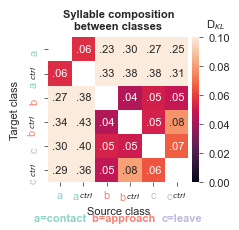

In [54]:
target_order = ["contact", "contact_control", "approach", "approach_control", "leave", "leave_control"]
# rename target order with second rename dict
target_order = [second_rename_dict.get(x, x) for x in target_order]

fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, ax = plt.subplots(figsize=fig_size)

axins = inset_axes(ax,
                    width="5%",  
                    height="100%",
                    loc='right',
                    borderpad=-1
                   )

data = polygon_dkl_series.unstack("polygon2").loc[target_order, target_order]
labels = data.applymap(lambda x: ("%.2f"%x)[1:] if not pd.isna(x) else "")
sns.heatmap(data, vmin=0, vmax=0.1, annot=labels, cbar=True, cbar_ax=axins, ax=ax, fmt="")

axins.annotate("D$_{KL}$", xy=(2.0, 1.04), xycoords="axes fraction", ha="left", va="bottom", annotation_clip=False, size=SMALL_SIZE)

ax.set_xlabel("Source class")
ax.set_ylabel("Target class")
ax.set_title("Syllable composition\nbetween classes", fontweight="bold", fontsize=SMALL_SIZE)

# add a text legend in left lower corner mapping a letter to a syntax class
legend_string = "a=contact  b=approach  c=leave"
legend_text = ax.text(0.5, -0.16, legend_string, ha='center', va='top', transform=ax.transAxes, fontsize=SMALL_SIZE, fontweight="bold")
rainbow_text(legend_text, ls=["a=contact  ", "b=approach  ", "c=leave"], lc=[polygon_colors["contact"], polygon_colors["approach"], polygon_colors["leave"]])

inverted_rename_dict = invert_flat_dict(second_rename_dict, unpack_single_values=True)
for ticklabel in ax.get_xticklabels():
    ticklabel_text = ticklabel.get_text()
    if len(ticklabel_text) > 1:
        rainbow_text(ticklabel, ls=[ticklabel_text[:1], ticklabel_text[1:]], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]], "k"])
    else:
        rainbow_text(ticklabel, ls=[ticklabel_text], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]]])

for ticklabel in ax.get_yticklabels():
    ticklabel_text = ticklabel.get_text()
    if len(ticklabel_text) > 1:
        rainbow_text(ticklabel, ls=[ticklabel_text[:1], ticklabel_text[1:]], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]], "k"])
    else:
        rainbow_text(ticklabel, ls=[ticklabel_text], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]]])

ax.tick_params(axis="x", pad=-3)
ax.set_xlabel("Source class", labelpad=7)
fig.subplots_adjust(right=0.55)
fig.set_size_inches(fig_size)

fig.tight_layout()

fig.savefig(plot_output_dir / "Fig4PanelF.svg", dpi=default_dpi)

## Panel G

C:\Users\rittmart\AppData\Local\Temp\ipykernel_116780\813284521.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


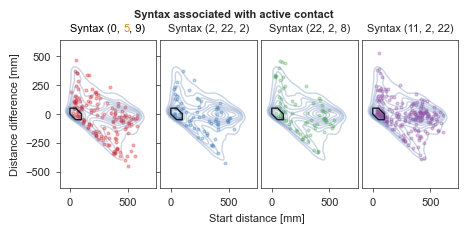

In [55]:
target_patterns = [(0, 5, 9), (2, 22, 2), (22, 2, 8), (11, 2, 22)]

pattern_strings_and_colors = {
    (0, 5, 9): (["Syntax (0, ", "5", ", 9)"], ["black", sig_color, "black"]),
}

fig_size_cm = (12, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(1, len(target_patterns), figsize=fig_size, sharey=True)
cmap = sns.color_palette("Set1", len(target_patterns))

for i, (target_pattern, pattern_ax) in enumerate(zip(target_patterns, axs.flatten())):
    sns.kdeplot(global_match_df_copy, x="start_distance", y="distance_difference", ax=pattern_ax, alpha=0.3)
    pattern_match_df = global_match_df_copy[global_match_df_copy["syllable_match"] == target_pattern]

    pattern_ax.scatter(x=pattern_match_df["start_distance"], y=pattern_match_df["distance_difference"], alpha=0.3, color=cmap[i])
    plot_polygon(clean_polygon_dict["contact"], name=None, ax=pattern_ax, polygon_kwargs=dict(fill=False, alpha=1, color="k", zorder=10))

    pattern_ax.set_title(f"Syntax {target_pattern}")

    if target_pattern in pattern_strings_and_colors:
        rainbow_text(pattern_ax.title, *pattern_strings_and_colors[target_pattern])

    if i==1:
        pattern_ax.set_xlabel("Start distance [mm]")
        pattern_ax.xaxis.set_label_coords(x=1, y=-0.17)
    else:
        pattern_ax.set_xlabel("")
        pattern_ax.tick_params(axis="y", left=False)
    if i==0:
        pattern_ax.tick_params(axis="y", left=True)
    pattern_ax.set_ylabel("Distance difference [mm]")
    pattern_ax.set_ylim([-diagonal_length, diagonal_length])
    pattern_ax.set_aspect('equal', adjustable='datalim')

fig.suptitle("Syntax associated with active contact", weight="bold", fontsize=SMALL_SIZE)
plt.tight_layout()
fig.subplots_adjust(top=0.85, wspace=0.05)

fig.savefig(plot_output_dir / "Fig4PanelG.svg", dpi=default_dpi)
fig.show()

# Figure 5

Height: 9

Width: 18

First row 

    Panel a: 9x4.5
    Panel c: 9x9
    
Second row

    Panel b: 9x4,5

## Panel A

In [56]:
syll_frequencies_df = load_object(data_output_dir / "syll_frequencies_df.pkl")

[0.30333934 0.16766882 0.10571756 0.10514406 0.05585828 0.04133192
 0.03380306 0.0271136  0.0231192  0.02122291 0.01850886 0.01506153
 0.01243362 0.01114287 0.00971929]
0.9511849192789459


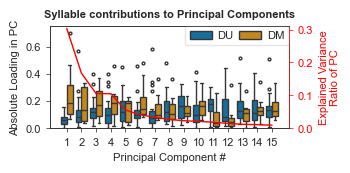

In [57]:
feature_hue_series = pd.Series([x in sig_syllables for x in syll_frequencies_df.columns], index=syll_frequencies_df.columns, name="dm_syllable")
input_df = syll_frequencies_df
max_components = 15
X = input_df

pipeline = make_pipeline(PCA(n_components=max_components)).fit(X)

component_df = pd.DataFrame(data=np.abs(pipeline[-1].components_.T), index=input_df.columns, columns=pd.Index(range(1, 16), name="PC")).stack().rename("abs_loading").to_frame()

if feature_hue_series is not None:
    component_df = component_df.join(feature_hue_series, how="left")
    _plot_kwargs = {"hue": feature_hue_series.name}
else:
    _plot_kwargs = {}


print(pipeline["pca"].explained_variance_ratio_)
print(np.sum(pipeline["pca"].explained_variance_ratio_))

fig_size_cm = (9, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, ax = plt.subplots(figsize=fig_size)
ax2 = ax.twinx()
# make right axis spine and ticks red
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

sns.boxplot(data=component_df.reset_index(), x="PC", y="abs_loading", ax=ax, palette="colorblind", **_plot_kwargs)
ax2.plot(pipeline["pca"].explained_variance_ratio_, color="red")

# rename legend title to Syllable and False to DU, True to DM
ax.legend(loc='upper right',ncol=2, framealpha=0.5, handletextpad=0.5, columnspacing=0.5, borderaxespad=0)
ax.get_legend().get_texts()[0].set_text("DU")
ax.get_legend().get_texts()[1].set_text("DM")

ax.set_xlabel("Principal Component #")
ax.set_ylabel("Absolute Loading in PC")
ax2.set_ylabel("Explained Variance\nRatio of PC", color="red")
ax.set_title("Syllable contributions to Principal Components", weight="bold", fontsize=SMALL_SIZE)

ax.set_ylim([0, 0.75])
ax2.set_ylim([0, 0.31])

fig.tight_layout()
fig.savefig(plot_output_dir / "Fig5PanelA.svg", dpi=default_dpi)

In [58]:
pipeline["pca"].explained_variance_ratio_[:5].sum()

np.float64(0.7377280570127298)

In [59]:
component_df

abs_loading  dm_syllable
syllable PC                          
0        1      0.106497        False
         2      0.277621        False
         3      0.228991        False
         4      0.184133        False
         5      0.317643        False
...                  ...          ...
31       11     0.161339        False
         12     0.041636        False
         13     0.065396        False
         14     0.071458        False
         15     0.092591        False

[480 rows x 2 columns]

In [60]:
first_4_pcs = component_df.loc[pd.IndexSlice[:, :5], :]
mannwhitneyu(first_4_pcs.loc[first_4_pcs["dm_syllable"], "abs_loading"], first_4_pcs.loc[~first_4_pcs["dm_syllable"], "abs_loading"], alternative="greater")

MannwhitneyuResult(statistic=np.float64(3239.0), pvalue=np.float64(0.0004763193390330502))

<Axes: xlabel='dm_syllable', ylabel='abs_loading'>

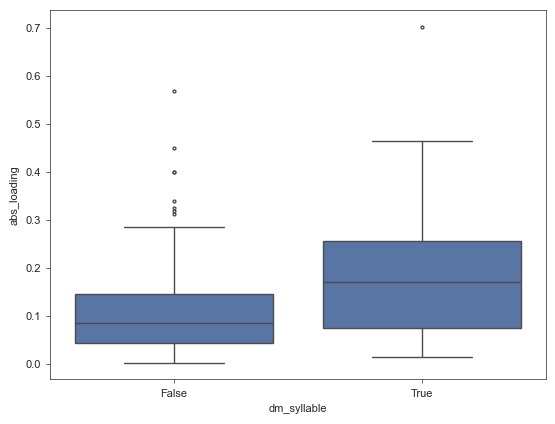

In [61]:
sns.boxplot(first_4_pcs.reset_index(), x="dm_syllable", y="abs_loading")

## Panel B

In [62]:
pattern_frequencies_df = load_object(data_output_dir / "pattern_frequencies_df.pkl")

[0.17954086 0.14282489 0.10972145 0.0863702  0.05362157 0.04601813
 0.03811422 0.03387343 0.02515602 0.02404666 0.02239846 0.02030739
 0.01911036 0.01832252 0.0170103 ]
0.8364364539190775


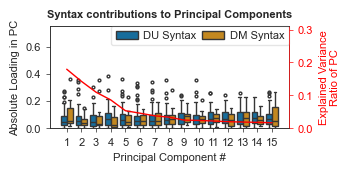

In [63]:
feature_hue_series = pd.Series(False, index=pattern_frequencies_df.columns, name="dm_syllable")
feature_hue_series = feature_hue_series.index.to_series().apply(pd.Series).isin(sig_syllables).sum(axis=1).ge(2).rename("dm_syntax")
input_df = pattern_frequencies_df
max_components = 15
X = input_df

pipeline = make_pipeline(PCA(n_components=max_components)).fit(X)

component_df = pd.DataFrame(data=np.abs(pipeline[-1].components_.T), index=input_df.columns, columns=pd.Index(range(1, 16), name="PC")).stack().rename("abs_loading").to_frame()

if feature_hue_series is not None:
    component_df = component_df.join(feature_hue_series, how="left")
    _plot_kwargs = {"hue": feature_hue_series.name}
else:
    _plot_kwargs = {}


print(pipeline["pca"].explained_variance_ratio_)
print(np.sum(pipeline["pca"].explained_variance_ratio_))

fig_size_cm = (9, 4.5)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, ax = plt.subplots(figsize=fig_size)
ax2 = ax.twinx()
# make right axis spine and ticks red
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

sns.boxplot(data=component_df.reset_index(), x="PC", y="abs_loading", ax=ax, palette="colorblind", **_plot_kwargs)
ax2.plot(pipeline["pca"].explained_variance_ratio_, color="red")

# rename legend title to Syllable and False to DU, True to DM
ax.legend(loc='upper right',ncol=2, framealpha=0.5, handletextpad=0.5, columnspacing=0.5, borderaxespad=0)
ax.get_legend().get_texts()[0].set_text("DU Syntax")
ax.get_legend().get_texts()[1].set_text("DM Syntax")

ax.set_xlabel("Principal Component #")
ax.set_ylabel("Absolute Loading in PC")
ax2.set_ylabel("Explained Variance\nRatio of PC", color="red")
ax.set_title("Syntax contributions to Principal Components", weight="bold")

ax.set_ylim([0, 0.75])
ax2.set_ylim([0, 0.31])

fig.tight_layout()
fig.savefig(plot_output_dir / "Fig5PanelB.svg", dpi=default_dpi)

In [64]:
pipeline["pca"].explained_variance_ratio_[:5].sum()

np.float64(0.5720789747847018)

In [65]:
first_4_pcs = component_df.loc[pd.IndexSlice[:, :5], :]
mannwhitneyu(first_4_pcs.loc[first_4_pcs["dm_syntax"], "abs_loading"], first_4_pcs.loc[~first_4_pcs["dm_syntax"], "abs_loading"], alternative="greater")

MannwhitneyuResult(statistic=np.float64(14638.0), pvalue=np.float64(0.8292733947989032))

<Axes: xlabel='dm_syntax', ylabel='abs_loading'>

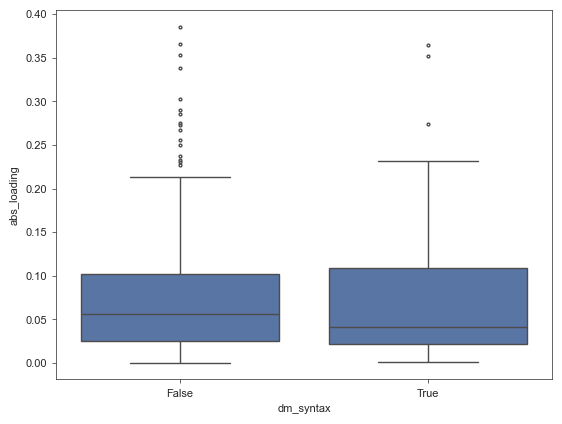

In [66]:
sns.boxplot(first_4_pcs.reset_index(), x="dm_syntax", y="abs_loading")

## Panel C

In [67]:
disc_df = load_object(data_output_dir / "disc_df.pkl")

In [68]:
disc_df = disc_df.rename({"norm": "Normal", "reverse": "Reversed"}, axis=0, level="group")
disc_df = disc_df.rename({"syllable": "Syllable", "syntax": "Syntax"}, axis=0, level="feature")
disc_df = disc_df.rename({"context": "Context", "light_cycle": "Light Cycle"}, axis=0, level="discriminant")
disc_df

PC1       PC2  \
discriminant group    feature  mouse_id_string track_id                       
Context      Dyadic   Syllable 1&4             0         0.013375 -0.037627   
                                               1         0.013547  0.029503   
                               13&16           0        -0.001438 -0.011381   
                                               1         0.059015  0.013114   
                               19&22           0         0.027283 -0.011782   
...                                                           ...       ...   
Light Cycle  Reversed Syntax   22              -1        0.006717  0.030875   
                               25              -1        0.031990 -0.017342   
                               28              -1        0.013854  0.031071   
                               4               -1        0.001154  0.018977   
                               7               -1        0.032419  0.019937   

                                                              PC3  
discriminant group    feature  mouse_id_string track_id            
Context      Dyadic   Syllable 1&4             0        -0.035452  
                                               1         0.023723  
                               13&16           0         0.018508  
                                               1         0.035325  
                               19&22           0         0.015742  
...                                                           ...  
Light Cycle  Reversed Syntax   22              -1       -0.004989  
                               25              -1       -0.029038  
                               28              -1       -0.043040  
                               4               -1        0.004421  
                               7               -1        0.003373  

[160 rows x 3 columns]

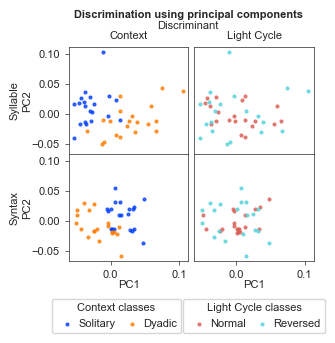

In [69]:
discriminant_level = "discriminant"

feature_level = "feature"
discriminant_level = "discriminant"
features = ["Syllable", "Syntax"]
discriminants = ["Context", "Light Cycle"]

group_level = "group"
discriminant_group_dict = {
    "Context": ["Solitary", "Dyadic"],
    "Light Cycle": ["Normal", "Reversed"]
}
discriminant_palette_dict = {
    "Context": sns.color_palette("bright", n_colors=2),
    "Light Cycle": sns.color_palette("hls", n_colors=2)
}

n_features = len(features)
n_discriminants = len(discriminants)

fig_size_cm = (9, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(n_features, n_discriminants, figsize=fig_size, sharex=True, sharey=True)

for i, (feature, discriminant) in enumerate(product(features, discriminants)):
    group_idx = list(features).index(feature)
    subgroup_idx = list(discriminants).index(discriminant)
    ax = axs[group_idx, subgroup_idx]

    df_slice = disc_df.xs((feature, discriminant), level=(feature_level, discriminant_level))

    groups = discriminant_group_dict[discriminant]
    for j, group in enumerate(groups):
        g_df = df_slice.xs(group, level=group_level)
        ax.scatter(g_df["PC1"], g_df["PC2"], label=group, alpha=0.75, color=discriminant_palette_dict[discriminant][j])
    if i>1:
        if i == 2:
            ax.legend(loc="upper center", bbox_to_anchor=(0.4, -0.35), ncol=2, title=f"{discriminant} classes", handletextpad=0, columnspacing=0.5, borderaxespad=0)
        if i == 3:
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.35), ncol=2, title=f"{discriminant} classes", handletextpad=0, columnspacing=0.5, borderaxespad=0)

    if i<2:
        ax.set_title(discriminant)
    if i%2==0:
        ax.set_ylabel(feature + "\nPC2", labelpad=0)
    else:
        ax.tick_params(axis="y", left=False)
    if i>1:
        ax.set_xlabel("PC1", labelpad=0)

fig.suptitle("Discrimination using principal components", weight="bold", fontsize=SMALL_SIZE, x=1, y=1.35, transform=axs[0,0].transAxes)

fig.text(1, 1.2, "Discriminant", ha='center', va='center', transform=axs[0, 0].transAxes)

fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0.05, left=0.25)

fig.savefig(plot_output_dir / "Fig5PanelC.svg", dpi=default_dpi)